1.1 Data Preparation and Loading (5%)
1. Write the code to create a SparkContext object using SparkSession, which tells Spark
how to access a cluster. To create a SparkSession you first need to build a SparkConf
object that contains information about your application. Give an appropriate name for
your application and run Spark locally with as many working processors as logical
cores on your machine.
2. Import all the “Units” csv files from 2015-2019 into a single RDD.
3. Import all the “Crashes” csv files from 2015-2019 into a single RDD.
4. For each Units and Crashes RDDs, remove the header rows and display the total
count and first 10 records. Hint : You can use csv.reader to parse rowsin RDDs.

1.1.1

In [16]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
master = "local[*]"
app_name = "ASS"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [17]:
from pyspark.rdd import RDD
import csv
# read all units files into one RDD by wildcard
unitRdd = sc.textFile("*_DATA_SA_Units.csv")
crashRdd = sc.textFile("*_DATA_SA_Crash.csv")

# get the header to be filtered
unitHeader = unitRdd.first()
crashHeader = crashRdd.first()
# remove the header1
unitRddWithoutHeader = unitRdd.filter(lambda x: x != unitHeader)
crashRddWithoutHeader = crashRdd.filter(lambda x: x != crashHeader)
# define the function to parse the data


def parseRecord(line):
    # Split line separated by comma
    array_line = line.replace('"', '').split(",")
    # Return a tuple with the car model as first element and the remaining as the second element
    return array_line


unitRddWithoutHeader = unitRddWithoutHeader.map(parseRecord)
crashRddWithoutHeader = crashRddWithoutHeader.map(parseRecord)
# count the total number
print("totalnum_unit: ", unitRddWithoutHeader.count())
print("totalnum_crash: ", crashRddWithoutHeader.count())
# take the first 10 records
print("first 10 unit: ", unitRddWithoutHeader.take(10))
print("first 10 unit: ", crashRddWithoutHeader.take(10))

totalnum_unit:  120770
totalnum_crash:  72006
first 10 unit:  [['2016-1-15/08/2019', '01', '0', 'SA', 'OMNIBUS', '2011', 'North', 'Male', '056', 'SA', 'HR', 'Full', 'Not Towing', 'Straight Ahead', '010', '5121', '', ''], ['2016-1-15/08/2019', '02', '1', '', 'Pedestrian on Road', '', 'East', 'Male', '072', '', '', '', '', 'Walking on Road', '', '5084', '', ''], ['2016-2-15/08/2019', '01', '0', 'SA', 'Motor Cars - Sedan', '2004', 'Unknown', 'Female', '023', 'SA', 'C ', 'Full', 'Not Towing', 'Straight Ahead', '001', '5087', '', ''], ['2016-2-15/08/2019', '02', '0', 'SA', 'Station Wagon', '2008', 'Unknown', 'Male', '040', 'SA', 'C ', 'Full', 'Not Towing', 'Straight Ahead', '001', '5084', '', ''], ['2016-3-15/08/2019', '01', '0', 'SA', 'RIGID TRUCK LGE GE 4.5T', '1990', 'South', 'Unknown', 'XXX', 'SA', 'MR', 'Provisional 2', 'Not Towing', 'Straight Ahead', '001', '5115', '', ''], ['2016-3-15/08/2019', '02', '0', 'SA', 'Panel Van', '2013', 'South', 'Male', '023', 'SA', 'C ', 'Full', 'Not Tow

1.2 Data Partitioning in RDD (10%)
1. How many partitions do the above RDDs have? How is the data in these RDDs
partitioned by default, when we do not explicitly specify any partitioning strategy?
2. In the “Units” csv dataset, there is a column called Lic State which shows the state
where the vehicle is registered. Assume we want to keep all the data related to SA in
one partition and the rest of the data in another partition.
a. Create a Key Value Pair RDD with Lic State as the key and rest of the other
columns as value.
b. Write the code to implement this partitioning in RDD using appropriate
partitioning functions.
c. Write the code to print the number of records in each partition. What does it
tell about the data skewness?

1.2.1

In [261]:
# using round-robin when not specified the partition strategy
print("###crash partition info:")
print("Number of partitions:{}".format(crashRdd.getNumPartitions()))
print("Partitioner:{}".format(crashRdd.partitioner))
print("###unit partition info:")
print("Number of partitions:{}".format(unitRdd.getNumPartitions()))
print("Partitioner:{}".format(unitRdd.partitioner))

###crash partition info:
Number of partitions:5
Partitioner:None
###unit partition info:
Number of partitions:4
Partitioner:None


In [94]:
print(unitHeader)

"REPORT_ID","Unit No","No Of Cas","Veh Reg State","Unit Type","Veh Year","Direction Of Travel","Sex","Age","Lic State","Licence Class","Licence Type","Towing","Unit Movement","Number Occupants","Postcode","Rollover","Fire"


1.2.2

In [18]:
# 1.2.2a create key-value pair
def transKV(line):
    backup1 = line
    backup2 = line
    line1 = line[:9]
    line2 = backup1[10:]
    lineFinal = line1 + line2
    return (backup2[9], lineFinal)


unitRddPair = unitRddWithoutHeader.map(transKV)
unitRddPair.take(10)
# 1.2.2b partition the data with "SA" to one partiotoin and others to another one
# def partitionSA(key):
#     index = 0
#     if key == "SA":
#         index = 0
#     else:
#         index = 1
#     return index
unitRddPairBySA = unitRddPair.partitionBy(2, lambda key: key == "SA")

# unitRddPairBySA = unitRddPair.partitionBy(2, partitionSA)
# 1.2.2c get number of records per partition
partitions = unitRddPairBySA.glom().collect()
for index, partition in enumerate(partitions):
    print("Partition Num:" + str(index))
    print(len(partition))

# check the number of "SA"
test = unitRddPair.filter(lambda x: x[0] == "SA")
test.count()

Partition Num:0
35707
Partition Num:1
85063


85063

In [62]:
import random
def transKV(line):
    backup1 = line
    backup2 = line
    line1 = line[:9]
    line2 = backup1[10:]
    lineFinal = line1 + line2
    return (backup2[9], lineFinal)


testRDD = unitRddWithoutHeader.map(transKV)
 

def noSkew(key):
    index = 0
    if key == "SA":
        index = random.randint(2,3)
    else:
        index = 1
    return index
testRDD = testRDD.partitionBy(3,noSkew)
partitions = testRDD.glom().collect()
for index, partition in enumerate(partitions):
    print("Partition Num:" + str(index))
    print(len(partition))


Partition Num:0
42813
Partition Num:1
35707
Partition Num:2
42250


1.3 Query/Analysis (10%)
For the Units RDD, write relevant RDD operations to answer the following queries.
1. Find the average age of male and female drivers separately.
2. What is the oldest and the newest vehicle year involved in the accident? Display the
Registration State, Year and Unit type of the vehicle.
女40.38；男40.9759

1.3.1

In [19]:
# filter the male and female
unitRddAge = unitRddWithoutHeader.filter(lambda x: x[7] in ["Male", "Female"])
# unitRddAge.take(5)
# filter the age that is digit and project the column sex and age out, then make a key value pair: (Sex, (age,1) ) to calculate the age
unitRddAge = unitRddAge.filter(lambda x: x[8].isdigit()).map(
    lambda x: (x[7], (int(x[8]), 1)))
# fist use reduceByKey to calculate the 'value': (age,1); then value part becomes ( totalAge, totalNumber )
# then use the map to calculate the pair part which is a tuple as above, use the tuple[0](totalAge) divide the tuple[1](Num) get the value
unitRddAge = unitRddAge.reduceByKey(lambda x, y: (
    x[0]+y[0], x[1]+y[1])).map(lambda x: (x[0], (x[1][0]/x[1][1])))
unitRddAge.collect()

[('Male', 41.08926862373188), ('Female', 40.49393590165734)]

1.3.2

In [20]:
# 1.3.2
# project the column used first
unitRddTemp = unitRddWithoutHeader.map(
    lambda field: (field[3], field[5], field[4]))
# filter the year that is a digit type and then convert it to int type
unitRddTemp = unitRddTemp.filter(lambda x: x[1].isdigit()).map(
    lambda x: (x[0], int(x[1]), x[2]))
unitRddMaxYear = unitRddTemp.max(key=lambda x: x[1])
print(unitRddMaxYear)
unitRddMinYear = unitRddTemp.min(key=lambda x: x[1])
print(unitRddMinYear)

('SA', 2019, 'Station Wagon')
('VIC', 1900, 'Motor Cycle')


-------

2.1 Data Preparation and Loading (5%)
1. Load all units and crash data into two separate dataframes.
2. Display the schema of the final two dataframes.

2.1.1 & 2.1.2

In [21]:
# Read data as dataframe
dfU = spark.read.format('csv')\
    .option('header', True).load('*_DATA_SA_Units.csv')
dfC = spark.read.format('csv')\
    .option('header', True).load('*_DATA_SA_Crash.csv')
# Create Views from Dataframes
dfU.createOrReplaceTempView("sqlU")
dfC.createOrReplaceTempView("sqlC")
# 2.1.2
dfU.printSchema()
dfC.printSchema()

root
 |-- REPORT_ID: string (nullable = true)
 |-- Unit No: string (nullable = true)
 |-- No Of Cas: string (nullable = true)
 |-- Veh Reg State: string (nullable = true)
 |-- Unit Type: string (nullable = true)
 |-- Veh Year: string (nullable = true)
 |-- Direction Of Travel: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Lic State: string (nullable = true)
 |-- Licence Class: string (nullable = true)
 |-- Licence Type: string (nullable = true)
 |-- Towing: string (nullable = true)
 |-- Unit Movement: string (nullable = true)
 |-- Number Occupants: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Rollover: string (nullable = true)
 |-- Fire: string (nullable = true)

root
 |-- REPORT_ID: string (nullable = true)
 |-- Stats Area: string (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- LGA Name: string (nullable = true)
 |-- Total Units: string (nullable = true)


2.2 Query/Analysis (15%)
Implement the following queries using dataframes. You need to be able to perform operations
like filtering, sorting, joining and group by using the functions provided by the DataFrame API.
1. Find all the crash events in Adelaide where the total number of casualties in the event
is more than 3.
2. Display 10 crash events with highest casualties.
3. Find the total number of fatalities for each crash type.
4. Find the total number of casualties for each suburb when the vehicle was driven by an
unlicensed driver. You are required to display the name of the suburb and the total
number of casualties.


2.2.1

In [23]:
# 2.2.1
from pyspark.sql.functions import col
import pyspark.sql.functions as F
# filter the casulty first
dfC1 = dfC.filter(col('Total Cas') > 3)
# filter the suburb
dfCForQ1 = dfC1.filter(col('Suburb') == "ADELAIDE")
# dfCForQ1.show(5)
print(dfCForQ1.count())

4


2.2.2

In [196]:
# 2.2.2Display 10 crash events with highest casualties.
dfCQ2 = dfC.sort('Total Cas', ascending=False)
dfCQ2.show(10)

+--------------------+--------------+---------------+--------+--------------------+-----------+---------+----------+--------+--------+----+--------+---------+--------+----------+-------------+--------------------+--------------+--------------+------------+-------------+------------+--------+-----------+---------+------------+-------------+---------------+------------+--------------+----------+----------+--------------+
|           REPORT_ID|    Stats Area|         Suburb|Postcode|            LGA Name|Total Units|Total Cas|Total Fats|Total SI|Total MI|Year|   Month|      Day|    Time|Area Speed|Position Type|    Horizontal Align|Vertical Align|    Other Feat|Road Surface|Moisture Cond|Weather Cond|DayNight| Crash Type|Unit Resp| Entity Code|CSEF Severity|  Traffic Ctrls|DUI Involved|Drugs Involved|  ACCLOC_X|  ACCLOC_Y|    UNIQUE_LOC|
+--------------------+--------------+---------------+--------+--------------------+-----------+---------+----------+--------+--------+----+--------+------

2.2.3

In [197]:
# 2.2.3
# Find the total number of fatalities for each crash type.
agg_attribute = 'Crash Type'
dfCQ3 = dfC.groupby(agg_attribute).agg(F.sum('Total Fats').alias('Total'))
dfCQ3.show()

+--------------------+-----+
|          Crash Type|Total|
+--------------------+-----+
|           Roll Over| 57.0|
|  Hit Object on Road|  2.0|
|      Hit Pedestrian| 70.0|
|    Hit Fixed Object|152.0|
|               Other|  2.0|
|          Side Swipe| 20.0|
|             Head On| 86.0|
|  Hit Parked Vehicle|  9.0|
|          Right Turn| 18.0|
|            Rear End| 16.0|
|          Hit Animal|  4.0|
|Left Road - Out o...|  1.0|
|         Right Angle| 45.0|
+--------------------+-----+



2.2.4

In [236]:
# 2.2.4
# Find the total number of casualties for each suburb when the vehicle was driven by an unlicensed driver.
# You are required to display the name of the suburb and the total number of casualties.
# do the join first
dfCQ4Temp = dfU.join(dfC, dfC['REPORT_ID'] == dfU['REPORT_ID'], how='left')
# then select the used columns
dfCQ4 = dfCQ4Temp.select('Suburb', 'Licence Type', 'Total Cas')
# do the filter,group...
dfCQ4 = dfCQ4Temp.filter(col('Licence Type') == "Unlicenced").groupBy(
    col('Suburb')).agg(F.sum('Total Cas').alias('Total'))
dfCQ4.show()

+-------------------+-----+
|             Suburb|Total|
+-------------------+-----+
|      FLINDERS PARK|  7.0|
|     TEA TREE GULLY|  1.0|
|            HACKHAM|  2.0|
|           WISANGER|  1.0|
|            CUMMINS|  0.0|
|       BASKET RANGE|  0.0|
|MURRAY BRIDGE SOUTH|  0.0|
|      GILLES PLAINS|  4.0|
|             HAWKER|  0.0|
|           BEAUFORT|  1.0|
|             MAGILL|  3.0|
|            CULTANA|  1.0|
|        EDWARDSTOWN|  4.0|
|          THORNGATE|  1.0|
|        RISDON PARK|  0.0|
|       ANDREWS FARM| 12.0|
|       TORRENSVILLE|  5.0|
|           SEACLIFF|  0.0|
|          CLARENDON|  0.0|
|          FREWVILLE|  0.0|
+-------------------+-----+
only showing top 20 rows



1. Find the total number of crash events for each severity level. Which severity level is the
most common?
2. Compute the total number of crash events for each severity level and the percentage
for the four different scenarios.
A sample output for each of these scenarios is given below.
`
a. When the driver is tested positive on drugs.
b. When the driver is tested positive for blood alcohol concentration.
c. When the driver is tested positive for both drugs and blood alcohol
d. When the driver is tested negative for both (no alcohol and no drugs).
Compare the results in these 4 scenarios. Briefly explain the observation from this
analysis.

2.3.1

In [30]:
# 2.3.1
dfCQ5 = dfC.groupBy(col('CSEF Severity')).agg(
    F.count('*').alias('COUNT'))
dfCQ5.show()

+-------------+-----+
|CSEF Severity|COUNT|
+-------------+-----+
|     4: Fatal|  451|
|        2: MI|21881|
|       1: PDO|46696|
|        3: SI| 2978|
+-------------+-----+



2.3.2

In [29]:
# 2.3.2  a
# filter the senario DRUG first
dfCD = dfC.filter(col('Drugs Involved') == "Y")
# make the table without percentage first
dfCD = dfCD.groupBy(col('CSEF Severity')).agg(
    F.count('*').alias('count'))
# calculate the total number of records of druged table
total = dfCD.select("count").agg(
    {"count": "sum"}).collect().pop()['sum(count)']
# add the column
dfCD = dfCD.withColumn('Percentage', (F.col('COUNT')/total)*100)
dfCD.show()

+-------------+-----+------------------+
|CSEF Severity|count|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|   82| 6.539074960127592|
|        2: MI|  749|59.728867623604465|
|       1: PDO|  176|14.035087719298245|
|        3: SI|  247|19.696969696969695|
+-------------+-----+------------------+



In [28]:
# 2.3.2  b
# filter the senario DRUG first
dfCD = dfC.filter(col('DUI Involved') == "Y")
# make the table without percentage first
dfCD = dfCD.groupBy(col('CSEF Severity')).agg(
    F.count('*').alias('count'))
# calculate the total number of records of druged table
total = dfCD.select("count").agg(
    {"count": "sum"}).collect().pop()['sum(count)']
# add the column
dfCD = dfCD.withColumn('Percentage', (F.col('COUNT')/total)*100)
dfCD.show()

+-------------+-----+------------------+
|CSEF Severity|count|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|   79|  3.51423487544484|
|        2: MI|  737|  32.7846975088968|
|       1: PDO| 1173|52.179715302491104|
|        3: SI|  259| 11.52135231316726|
+-------------+-----+------------------+



In [27]:
# 2.3.2  c
# filter the senario first
dfCD = dfC.filter(col('Drugs Involved') == "Y").filter(
    col('DUI Involved') == "Y")
# make the table without percentage first
dfCD = dfCD.groupBy(col('CSEF Severity')).agg(
    F.count('*').alias('count'))
# calculate the total number of records of druged table
total = dfCD.select("count").agg(
    {"count": "sum"}).collect().pop()['sum(count)']
# add the column
dfCD = dfCD.withColumn('Percentage', (F.col('COUNT')/total)*100)
dfCD.show()

+-------------+-----+------------------+
|CSEF Severity|count|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|   27|15.428571428571427|
|        2: MI|   89|50.857142857142854|
|       1: PDO|   24|13.714285714285715|
|        3: SI|   35|              20.0|
+-------------+-----+------------------+



In [31]:
# 2.3.2  d
# filter the senario first
dfCD = dfC.filter(col('Drugs Involved').isNull())
dfCD = dfC.filter(col('DUI Involved').isNull())
# make the table without percentage first
dfCD = dfCD.groupBy(col('CSEF Severity')).agg(
    F.count('*').alias('count'))
# calculate the total number of records of druged table
total = dfCD.select("count").agg(
    {"count": "sum"}).collect().pop()['sum(count)']
# add the column
dfCD = dfCD.withColumn('Percentage', (F.col('COUNT')/total)*100)
dfCD.show()

+-------------+-----+------------------+
|CSEF Severity|count|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|  372|0.5332721695002725|
|        2: MI|21144|30.310502021273543|
|       1: PDO|45523| 65.25846497892715|
|        3: SI| 2719| 3.897760830299034|
+-------------+-----+------------------+



2.4 RDDs vs DataFrame vs Spark SQL (20%)
Implement the following queries using RDDs, DataFrames and SparkSQL separately. Log the
time taken for each query in each approach using the “%%time” built-in magic command in
Jupyter Notebook and discuss the performance difference of these 3 approaches.
1. Find the Date and Time of Crash, Number of Casualties in each unit and the Gender,
1
Age, License Type of the unit driver for the suburb "Adelaide".
2. Find the total number of casualties for each suburb when the vehicle was driven by an
unlicensed driver. You are required to display the name of the suburb and the total
number of casualties

2.4.1

In [323]:
print("c:" + crashHeader)
print("u:" + unitHeader)
# DATE: c[10-12] Time:c[13] Gender:u[7] Age:u[8] LT:u[11] Suburb:c[2]

c:"REPORT_ID","Stats Area","Suburb","Postcode","LGA Name","Total Units","Total Cas","Total Fats","Total SI","Total MI","Year","Month","Day","Time","Area Speed","Position Type","Horizontal Align","Vertical Align","Other Feat","Road Surface","Moisture Cond","Weather Cond","DayNight","Crash Type","Unit Resp","Entity Code","CSEF Severity","Traffic Ctrls","DUI Involved","Drugs Involved","ACCLOC_X","ACCLOC_Y","UNIQUE_LOC"
u:"REPORT_ID","Unit No","No Of Cas","Veh Reg State","Unit Type","Veh Year","Direction Of Travel","Sex","Age","Lic State","Licence Class","Licence Type","Towing","Unit Movement","Number Occupants","Postcode","Rollover","Fire"


2.4.1 RDD

In [363]:
% % time
# project the column used first, then filter the suburb "Ad..", then change the format of date and make a key value pair
rddCTemp = crashRddWithoutHeader.map(lambda x: (x[0], x[10], x[11], x[12], x[13], x[2], x[6])).filter(lambda x: x[5] == "ADELAIDE")\
    .map(lambda x: (x[0], (x[1] + '-' + x[2] + '-' + x[3], x[4], x[6])))
# project the column used from unit
rddUTemp = unitRddWithoutHeader.map(lambda x: (x[0], (x[7], x[8], x[11])))
rddJoin1 = rddCTemp.join(rddUTemp)
rddJoin1.collect()

CPU times: user 32.7 ms, sys: 0 ns, total: 32.7 ms
Wall time: 1.92 s


[('2019-113-8/07/2020',
  (('2019-January-Sunday', '09:55 am', '0'), ('Female', '038', 'Full'))),
 ('2019-113-8/07/2020',
  (('2019-January-Sunday', '09:55 am', '0'), ('', '', ''))),
 ('2019-274-8/07/2020',
  (('2019-January-Thursday', '07:15 pm', '0'),
   ('Male', '020', 'Provisional 2'))),
 ('2019-274-8/07/2020',
  (('2019-January-Thursday', '07:15 pm', '0'), ('Male', '021', 'Full'))),
 ('2019-717-8/07/2020',
  (('2019-January-Thursday', '05:20 pm', '0'), ('Female', '042', 'Full'))),
 ('2019-717-8/07/2020',
  (('2019-January-Thursday', '05:20 pm', '0'), ('Female', '047', 'Full'))),
 ('2019-730-8/07/2020',
  (('2019-January-Friday', '11:00 am', '0'), ('Female', '025', 'Full'))),
 ('2019-730-8/07/2020',
  (('2019-January-Friday', '11:00 am', '0'), ('Unknown', 'XXX', 'Unknown'))),
 ('2019-860-8/07/2020',
  (('2019-January-Wednesday', '09:00 am', '1'), ('Female', '038', 'Full'))),
 ('2019-860-8/07/2020',
  (('2019-January-Wednesday', '09:00 am', '1'), ('Female', '040', ''))),
 ('2019-985

2.4.1 DF

In [370]:
% % time
# select used column and concat the date column
dfCT1 = dfC.select('REPORT_ID', 'Suburb', 'Year', 'Month', 'Day',
                   'Time', 'Total Cas').filter(col('Suburb') == "ADELAIDE")
dfCT1 = dfCT1.withColumn('Date', F.concat(col('Year'), F.lit('-'), F.col('Month'), F.lit('-'), col('Day')))\
    .select(col('REPORT_ID'), col('Suburb'), col('Time'), col('Date'), col('Total Cas'))

dfUT1 = dfU.select('REPORT_ID', 'Sex', 'Age', 'Licence Type')

dfJoin1 = dfCT1.join(dfUT1, dfCT1.REPORT_ID == dfUT1.REPORT_ID, how='full')
dfJoin1.show()

+--------------------+--------+--------+--------------------+---------+--------------------+------+----+------------+
|           REPORT_ID|  Suburb|    Time|                Date|Total Cas|           REPORT_ID|   Sex| Age|Licence Type|
+--------------------+--------+--------+--------------------+---------+--------------------+------+----+------------+
|2015-1222-21/08/2019|ADELAIDE|10:10 am|2015-January-Thur...|        0|                null|  null|null|        null|
|2015-1688-21/08/2019|ADELAIDE|04:47 pm|2015-February-Tue...|        0|                null|  null|null|        null|
|2015-1786-21/08/2019|ADELAIDE|04:20 pm|2015-February-Thu...|        0|                null|  null|null|        null|
|                null|    null|    null|                null|     null|2016-10482-15/08/...|  Male| 020|        Full|
|                null|    null|    null|                null|     null|2016-10482-15/08/...|  Male| 055|        Full|
|2016-10682-15/08/...|ADELAIDE|11:45 am|    2016-July-Fr

2.4.1SQL

In [410]:
% % time
sqlQ1 = spark.sql('''
  SELECT c.Year || '-' || c.Month || '-' || c.Day AS Date, c.Time ,`Total Cas`,u.Sex,u.Age,`Licence Type`
  FROM sqlU u JOIN sqlC c
  ON u.REPORT_ID = c.REPORT_ID
  WHERE c.Suburb = "ADELAIDE"
''')
sqlQ1.show()

+--------------------+--------+---------+-------+----+------------+
|                Date|    Time|Total Cas|    Sex| Age|Licence Type|
+--------------------+--------+---------+-------+----+------------+
|2016-November-Wed...|01:45 pm|        1|   Male| 072|        null|
|2016-November-Wed...|01:45 pm|        1|   Male| 056|        Full|
|2016-November-Tue...|03:40 pm|        1| Female| 027|        null|
|2016-November-Tue...|03:40 pm|        1|   Male| 056|        null|
|2016-November-Tue...|05:00 pm|        0|Unknown| XXX|     Unknown|
|2016-November-Tue...|05:00 pm|        0| Female| 032|        Full|
|2016-November-Tue...|05:40 pm|        0|   Male| 020|     Unknown|
|2016-November-Tue...|05:40 pm|        0|   Male| 022|     Unknown|
|2016-November-Monday|11:26 pm|        0|   null|null|        null|
|2016-November-Monday|11:26 pm|        0|   Male| 042|        Full|
|2016-November-Monday|11:26 pm|        0|Unknown| XXX|     Unknown|
|2016-November-Monday|11:30 pm|        0|   Male

2.4.2. Find the total number of casualties for each suburb when the vehicle was driven by an
unlicensed driver. You are required to display the name of the suburb and the total
number of casualties

2.4.2 rdd

c:
"REPORT_ID","Stats Area","Suburb","Postcode","LGA Name","Total Units","Total Cas","Total Fats","Total SI","Total MI","Year","Month","Day","Time","Area Speed","Position Type","Horizontal Align","Vertical Align","Other Feat","Road Surface","Moisture Cond","Weather Cond","DayNight","Crash Type","Unit Resp","Entity Code","CSEF Severity","Traffic Ctrls","DUI Involved","Drugs Involved","ACCLOC_X","ACCLOC_Y","UNIQUE_LOC"
u:
"REPORT_ID","Unit No","No Of Cas","Veh Reg State","Unit Type","Veh Year","Direction Of Travel","Sex","Age","Lic State","Licence Class","Licence Type","Towing","Unit Movement","Number Occupants","Postcode","Rollover","Fire"

In [405]:
% % time
# select the used column first
rddC_unCas = crashRddWithoutHeader.map(lambda x: (x[0], (x[2], x[6])))
# rddC_unCas.take(3)
rddU_unCas = unitRddWithoutHeader.map(lambda x: (
    x[0], x[11])).filter(lambda x: x[1] == "Unlicenced")
rddJoin2 = rddC_unCas.join(rddU_unCas)
# select suburb and cas from the joined rdd to be as a key value pair do the reduceby funtion
rddJoin2 = rddJoin2.map(lambda x: x[1][0])
# add the value part which is cas together
rddJoin2 = rddJoin2.reduceByKey(lambda x, y: x + y)
rddJoin2.take(3)

CPU times: user 45.6 ms, sys: 1.55 ms, total: 47.2 ms
Wall time: 1.94 s


[('KLEMZIG', '000201'), ('WATERLOO CORNER', '110012'), ('HINDMARSH', '00100')]

2.4.2df

In [407]:
% % time
dfCT2 = dfC.select('REPORT_ID', 'Suburb', 'Total Cas')

dfUT2 = dfU.select('REPORT_ID', 'Licence Type').filter(
    col('Licence Type') == "Unlicenced")

dfJoin2 = dfCT2.join(dfUT2, dfCT2.REPORT_ID == dfUT2.REPORT_ID, how='inner').groupBy(
    col('Suburb')).agg(F.sum(col('Total Cas')).alias('Total'))

dfJoin2.show(2)

+--------------+-----+
|        Suburb|Total|
+--------------+-----+
| FLINDERS PARK|  7.0|
|TEA TREE GULLY|  1.0|
+--------------+-----+
only showing top 2 rows

CPU times: user 6.84 ms, sys: 0 ns, total: 6.84 ms
Wall time: 972 ms


2.4.2sql

In [415]:
% % time
sqlQ4 = spark.sql('''
  SELECT Suburb, sum(`Total Cas`)
  FROM sqlU u JOIN sqlC c ON u.REPORT_ID = c.REPORT_ID
  WHERE `Licence Type` = "Unlicenced"
  GROUP BY Suburb
''')
sqlQ4.show()

+-------------------+------------------------------+
|             Suburb|sum(CAST(Total Cas AS DOUBLE))|
+-------------------+------------------------------+
|      FLINDERS PARK|                           7.0|
|     TEA TREE GULLY|                           1.0|
|            HACKHAM|                           2.0|
|           WISANGER|                           1.0|
|            CUMMINS|                           0.0|
|       BASKET RANGE|                           0.0|
|MURRAY BRIDGE SOUTH|                           0.0|
|      GILLES PLAINS|                           4.0|
|             HAWKER|                           0.0|
|           BEAUFORT|                           1.0|
|             MAGILL|                           3.0|
|            CULTANA|                           1.0|
|        EDWARDSTOWN|                           4.0|
|          THORNGATE|                           1.0|
|        RISDON PARK|                           0.0|
|       ANDREWS FARM|                         

/home/student/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/student/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)


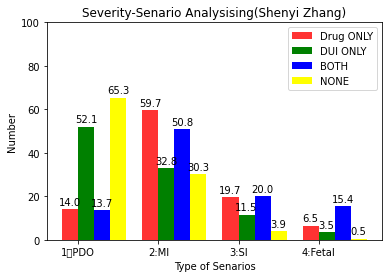

In [49]:
import matplotlib.pyplot as plt
import matplotlib
# 横坐标
label_list = ['1：PDO', '2:MI', '3:SI', '4:Fetal']

# 纵坐标
drug = [14, 59.7, 19.7, 6.5]
dui = [52.1, 32.8, 11.5, 3.5]
both = [13.7, 50.8, 20.0, 15.4]
neither = [65.3, 30.3, 3.9, 0.5]
x = range(len(drug))

rectDrug = plt.bar(x=x, height=drug, width=0.2, alpha=0.8,
                   color='red', label="Drug ONLY")
rectDui = plt.bar(x=[i + 0.2 for i in x], height=dui,
                  width=0.2, color='green', label="DUI ONLY")
rectBoth = plt.bar(x=[i + 0.4 for i in x], height=both,
                   width=0.2, color='blue', label="BOTH")
rectNone = plt.bar(x=[i + 0.6 for i in x], height=neither,
                   width=0.2, color='yellow', label="NONE")

plt.ylim(0, 100)     # y range
plt.ylabel("Number")

plt.xticks([index + 0.1 for index in x], label_list)
plt.xlabel("Type of Senarios")
plt.title("Severity-Senario Analysising(Shenyi Zhang)")

for rect in rectDrug:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")
for rect in rectDui:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")
for rect in rectBoth:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")
for rect in rectNone:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")

plt.legend(loc="upper right")
plt.show()

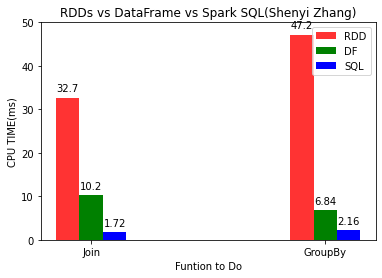

In [50]:
label_list = ['Join', 'GroupBy']
rectRDD = [32.7, 47.2]
rectDF = [10.2, 6.84]
rectSQL = [1.72, 2.16]
x = range(len(rectRDD))
rectRDD = plt.bar(x=x, height=rectRDD, width=0.1, alpha=0.8,
                  color='red', label="RDD")
rectDF = plt.bar(x=[i + 0.1 for i in x], height=rectDF,
                 width=0.1, color='green', label="DF")
rectSQL = plt.bar(x=[i + 0.2 for i in x], height=rectSQL,
                  width=0.1, color='blue', label="SQL")
plt.ylim(0, 50)     # y range
plt.ylabel("CPU TIME(ms)")
plt.xticks([index + 0.1 for index in x], label_list)
plt.xlabel("Funtion to Do")
plt.title("RDDs vs DataFrame vs Spark SQL(Shenyi Zhang)")
for rect in rectRDD:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")
for rect in rectDF:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")
for rect in rectSQL:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")
    plt.legend(loc="upper right")
plt.show()